In [ ]:
## General Notes

In [3]:
#### All dependencies

## Data collection and visualisation

import yfinance as yf
import pandas as pd
from pandas import  read_csv
from pandas import set_option
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib.dates as mpl_dates


import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

plt.style.use('seaborn-darkgrid')


## Prediction Engine, Featuring Engineering, Model Evaluation
import warnings
warnings.filterwarnings('ignore')
import os
# import pandas as pd
import numpy as np
import math
import datetime as dt
# import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

from itertools import product
import statsmodels.api as sm

import tensorflow as tf

from keras.models import Sequential
from keras.models import load_model
from keras.layers import Activation, Dense, Dropout
from keras.layers import LSTM

from itertools import cycle
# import plotly.offline as py
# import plotly.graph_objects as go
# import plotly.express as px
# from plotly.subplots import make_subplots

# plt.style.use('seaborn-darkgrid')



In [51]:
#### Data Engineering


df = pd.DataFrame()

crypto_ticker = ['BTC', 'ETH', 'USDT']


#Extract data for each of the 10 coins from YahooFinance! using a For loop.
for each_crypto_ticker in crypto_ticker:

    each_crypto_ticker_index = crypto_ticker.index(each_crypto_ticker)
    crypto_data = yf.Ticker(f"{each_crypto_ticker}-USD").history(start='2015-01-01', end='2022-07-31', interval='1d')
    crypto_dataframe = pd.DataFrame(crypto_data)
    crypto_dataframe['crypto_ticker'] = each_crypto_ticker
    df = pd.concat([df, crypto_dataframe])


set_option('display.width', 500)
df = df.rename_axis('cryptodate').reset_index()

# ###Convert data to CSV and store it
df.to_csv("soligencecryptodata_withdate.csv")

###Extract data to different dataframes to simplify data understanding for each cryptocurrency
BTC = df.loc[df['crypto_ticker'] == 'BTC']
ETH = df.loc[df['crypto_ticker'] == 'ETH']
USDT = df.loc[df['crypto_ticker'] == 'USDT']


df

,cryptodate,Open,High,Low,Close,Volume,Dividends,Stock Splits,crypto_ticker
0,2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550,0,0,BTC
1,2015-01-02,314.079010,315.838989,313.565002,315.032013,7860650,0,0,BTC
2,2015-01-03,314.846008,315.149994,281.082001,281.082001,33054400,0,0,BTC
3,2015-01-04,281.145996,287.230011,257.612000,264.195007,55629100,0,0,BTC
4,2015-01-05,265.084015,278.341003,265.084015,274.473999,43962800,0,0,BTC
...,...,...,...,...,...,...,...,...,...
6213,2022-07-26,1.000067,1.000128,0.999996,1.000047,48266723630,0,0,USDT
6214,2022-07-27,1.000048,1.000328,0.999980,1.000274,60104591185,0,0,USDT
6215,2022-07-28,1.000288,1.000360,1.000123,1.000200,75754591120,0,0,USDT
6216,2022-07-29,1.000205,1.000346,1.000169,1.000311,72013108986,0,0,USDT


In [161]:
#### Feature Engineering


# Obtain data for feature
close_price = BTC.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'crypto_ticker', 'cryptodate'])

# Split data into training and test data 80% for training data and 20% for test data
prediction_period = 554 # In days
training_data = close_price[:len(close_price)-prediction_period].values.reshape(-1,1)
testing_data = close_price[len(close_price)-prediction_period:].values.reshape(-1,1)

# Scale the data
scaled_td = MinMaxScaler(feature_range=(0,1))
scaled_td = scaled_td.fit_transform(training_data)


scaled_ts = MinMaxScaler(feature_range=(0,1))
scaled_ts = scaled_ts.fit_transform(testing_data)


#Create a series of timesteps and observations for X and Y axis for test and training data

def split_x_and_yaxis(dataset, look_back=3):

    Xaxis_data, Yaxis_data = [], []

    for i in range(len(dataset) - look_back):
        prediction_look_back = dataset[i:(i + look_back), 0]
        Xaxis_data.append(prediction_look_back)
        Yaxis_data.append(dataset[i + look_back, 0]) # this is the label or actual y-value
    return np.array(Xaxis_data), np.array(Yaxis_data)

training_data_X, training_data_Y = split_x_and_yaxis(scaled_td)
testing_data_X, testing_data_Y = split_x_and_yaxis(scaled_ts)

training_data_Y

## View shape of the datasets
# print(training_data_X.shape)
# print(training_data_Y.shape)
# print(testing_data_X.shape)
# print(testing_data_Y.shape)

## Reshape data to 3D Tensors for LSTM for (Samples, timesteps, features)
# Batch size, timesteps or lookback, target features

training_data_X_3D_Tensor = np.reshape(training_data_X, (training_data_X.shape[0], training_data_X.shape[1], 1))
testing_data_X_3D_Tensor = np.reshape(testing_data_X, (testing_data_X.shape[0], testing_data_X.shape[1], 1 ))

print("Shape of training_data_X_3D_Tensor: ", training_data_X_3D_Tensor.shape)
print("Shape of testing_data_X_3D_Tensor: ", testing_data_X_3D_Tensor.shape)


Shape of training_data_X_3D_Tensor:  (2211, 3, 1)
Shape of testing_data_X_3D_Tensor:  (551, 3, 1)


In [159]:
new_test_scaler = pd.DataFrame(scaled_ts)
new_test_scaler
print(scaled_ts)

[[0.26879957]
 [0.27336682]
 [0.27495312]
 [0.27914386]
 [0.23512041]
 [0.29760448]
 [0.31511845]
 [0.31415318]
 [0.29035949]
 [0.29906852]
 [0.33971005]
 [0.38011858]
 [0.36887177]
 [0.39396471]
 [0.41706918]
 [0.40960108]
 [0.55982035]
 [0.56568329]
 [0.53349074]
 [0.59510142]
 [0.58677007]
 [0.57854468]
 [0.61174345]
 [0.59583731]
 [0.62168352]
 [0.68242886]
 [0.67276421]
 [0.75944611]
 [0.76380019]
 [0.7934696 ]
 [0.72482529]
 [0.61395022]
 [0.63209484]
 [0.57830443]
 [0.56277194]
 [0.55965533]
 [0.5380137 ]
 [0.63056876]
 [0.60477525]
 [0.64925084]
 [0.60852772]
 [0.61606929]
 [0.61576193]
 [0.66301934]
 [0.68443745]
 [0.73752987]
 [0.76192644]
 [0.7989316 ]
 [0.78918826]
 [0.86974566]
 [0.82977033]
 [0.75983884]
 [0.77832943]
 [0.82088405]
 [0.80003977]
 [0.81008588]
 [0.809406  ]
 [0.79312925]
 [0.73145412]
 [0.73577553]
 [0.69530771]
 [0.67326603]
 [0.74398097]
 [0.76120472]
 [0.7607358 ]
 [0.79780034]
 [0.82184795]
 [0.82187145]
 [0.82551675]
 [0.83145926]
 [0.79478672]
 [0.81

In [152]:
#### LSTM Prediction Engine

##Create the LSTM Model

regressor = Sequential()
# First Layer
regressor.add(LSTM(units = 128, activation = 'relu',return_sequences=True, input_shape = (training_data_X_3D_Tensor.shape[1], training_data_X_3D_Tensor.shape[2])))
regressor.add(Dropout(0.2))
# Second Layer
regressor.add(LSTM(units = 64, input_shape = (training_data_X_3D_Tensor.shape[1], training_data_X_3D_Tensor.shape[2])))
regressor.add(Dropout(0.2))
# Adding the output layer
regressor.add(Dense(units = 1))
regressor.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 3, 128)            66560     
                                                                 
 dropout_8 (Dropout)         (None, 3, 128)            0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 116,033
Trainable params: 116,033
Non-trainable params: 0
_________________________________________________________________


In [153]:

## Compile the LSTM model

from  keras.callbacks import ModelCheckpoint, EarlyStopping

# Compiling the LSTM
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

checkpoint_path = 'my_best_model.hdf5'

checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')


earlystopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

callbacks = [checkpoint, earlystopping]


history = regressor.fit(training_data_X_3D_Tensor, training_data_Y, batch_size = 32, epochs = 150, verbose=1, shuffle=False, validation_data=(testing_data_X_3D_Tensor, testing_data_Y), callbacks=callbacks)

Epoch 1/150
62/70 [=========================>....] - ETA: 0s - loss: 0.0047
Epoch 1: val_loss improved from inf to 0.04676, saving model to my_best_model.hdf5
70/70 [==============================] - 4s 15ms/step - loss: 0.0082 - val_loss: 0.0468
Epoch 2/150
61/70 [=========================>....] - ETA: 0s - loss: 0.0177
Epoch 2: val_loss improved from 0.04676 to 0.00867, saving model to my_best_model.hdf5
70/70 [==============================] - 1s 7ms/step - loss: 0.0167 - val_loss: 0.0087
Epoch 3/150
62/70 [=========================>....] - ETA: 0s - loss: 0.0042
Epoch 3: val_loss improved from 0.00867 to 0.00325, saving model to my_best_model.hdf5
70/70 [==============================] - 1s 7ms/step - loss: 0.0042 - val_loss: 0.0033
Epoch 4/150
61/70 [=========================>....] - ETA: 0s - loss: 0.0034
Epoch 4: val_loss did not improve from 0.00325
70/70 [==============================] - 0s 7ms/step - loss: 0.0039 - val_loss: 0.0067
Epoch 5/150
64/70 [========================

In [154]:
## Save LSTM Model
#
from  keras.models import load_model

model_from_saved_checkpoint = load_model(checkpoint_path)

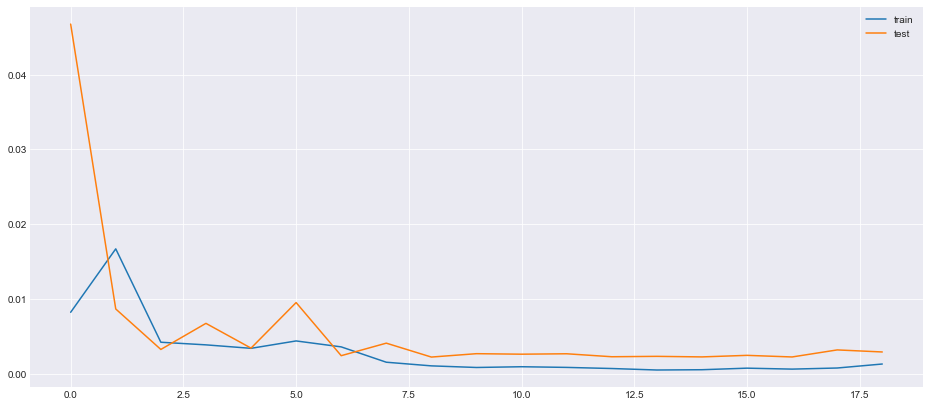

In [155]:
## Visualise Loss

plt.figure(figsize=(16,7))
plt.plot(history.history['loss'], label='train')

plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [156]:
# Transformation to original form and making the predictions

# predicted_btc_price_test_data = regressor.predict(testX)
test_predicted = model_from_saved_checkpoint.predict(testing_data_X)

test_predicted = scaled_ts.inverse_transform(test_predicted.reshape(-1, 1))
test_actual = scaled_ts.inverse_transform(testing_data_Y.reshape(-1, 1))

18/18 [==============================] - 1s 2ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'inverse_transform'

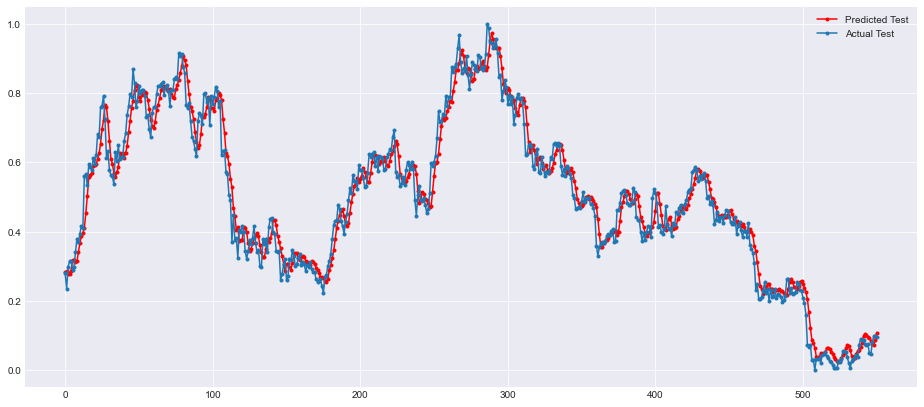

In [85]:
plt.figure(figsize=(16,7))

plt.plot(test_predicted, 'r', marker='.', label='Predicted Test')

plt.plot(testing_data_Y, marker='.', label='Actual Test')

plt.legend()
plt.show()

In [134]:
## Future 5 days

testing_data_X_3D_Tensor.shape
look_back = 5
past_5days = testing_data_X_3D_Tensor[testing_data_X_3D_Tensor.shape[0] - look_back :]

past_5days.shape
past_5days

future_days = []
for i in range(5):
    forecast_test_x = model_from_saved_checkpoint.predict(past_5days[i:i+1])
    forecast_test_x = scaled_ts.inverse_transform(forecast_test_x.reshape(-1,1))
    future_days.append(forecast_test_x)

print ("Forecast:", np.array(future_days))



###Save this to trouble shoot scaled issues having Attribute Error
# future_days = []
# for i in range(5):
#     future_days = model_from_saved_checkpoint.predict(past_5days[i:i+1])
#     # forecast_test_x = scaled_ts.inverse_transform(forecast_test_x.reshape(-1,1))
#     future_days.append(future_days)
#
# print ("Forecast:", np.array(future_days))


1/1 [==============================] - 0s 21ms/step


AttributeError: 'numpy.ndarray' object has no attribute 'inverse_transform'

In [ ]:


#### Data Visualisations


fig, ax = plt.subplots(1, figsize=(13, 7))

ax.plot(training_data, label='Train', linewidth=2)
ax.plot(testing_data, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('BitCoin Closeprice Train-Test Data', fontsize=16)
ax.legend(loc='best', fontsize=16)

# Scaled Data
fig, ax = plt.subplots(1, figsize=(13, 7))

ax.plot(scaled_td, label='Train', linewidth=2)
ax.plot(scaled_ts, label='Test', linewidth=2)
ax.set_ylabel('Price USD', fontsize=14)
ax.set_title('BitCoin Closeprice Train-Test Data', fontsize=16)
ax.legend(loc='best', fontsize=16)

In [40]:
scaled_ts

array([[0.26879957],
       [0.27336682],
       [0.27495312],
       [0.27914386],
       [0.23512041],
       [0.29760448],
       [0.31511845],
       [0.31415318],
       [0.29035949],
       [0.29906852],
       [0.33971005],
       [0.38011858],
       [0.36887177],
       [0.39396471],
       [0.41706918],
       [0.40960108],
       [0.55982035],
       [0.56568329],
       [0.53349074],
       [0.59510142],
       [0.58677007],
       [0.57854468],
       [0.61174345],
       [0.59583731],
       [0.62168352],
       [0.68242886],
       [0.67276421],
       [0.75944611],
       [0.76380019],
       [0.7934696 ],
       [0.72482529],
       [0.61395022],
       [0.63209484],
       [0.57830443],
       [0.56277194],
       [0.55965533],
       [0.5380137 ],
       [0.63056876],
       [0.60477525],
       [0.64925084],
       [0.60852772],
       [0.61606929],
       [0.61576193],
       [0.66301934],
       [0.68443745],
       [0.73752987],
       [0.76192644],
       [0.798

In [ ]:
#### Feature Engineering

de
allcrypto_cp = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Dividends', 'Stock Splits', 'crypto_ticker', 'Close'])

